In [41]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.stats import gaussian_kde

In [34]:
#loading up data frame and subsetting it to Texas and variable of interests
dfb = pd.read_csv('/home/minh/portfolio/census/pums/ss13pusb.csv')
data = dfb.loc[dfb['ST'] == 48, ['ST','WAGP','RAC1P', "JWMNP"]]

#renaming columns
data = data.rename(columns = {
    'ST': 'state',
    'WAGP': 'wage',
    'RAC1P': 'race',
    'JWMNP': 'commute'
})
#save file 
data.to_csv('/home/minh/portfolio/census/data.csv') 

In [3]:
#use this file for subsequent analysis
data = pd.read_csv('/home/minh/portfolio/census/data.csv')

In [5]:
#preprocessing and exploratory analysis

#removing missing data
data = data[np.isfinite(data['commute'])] 

#renaming the numeric code into strings
data['race'] = data['race'].astype('category')
race = {"White": [1], "Black": [2], "American or Alaskan Native": [3,4,5], "Asian/Pacific Islander": [6,7],
    "Other Race": [8], "Two or More Races": [9]}
race2 = {v: k for k,vv in race.items() for v in vv}
data['race'] = data['race'].map(race2).astype("category", categories = set(race2.values()))

#scaling data
data['commute'].describe()
data['wage'].describe()
data['wage_scaled'] = (data['wage'] - data['wage'].mean())/data['wage'].std()
data['wage_scaled'].describe()
data_scaled = data[(data['wage_scaled'] < 3) & (data['wage_scaled'] > -3)]

In [6]:
data_scaled['wage'].describe()

count    104682.000000
mean      39935.226744
std       36003.812477
min           0.000000
25%       14000.000000
50%       30000.000000
75%       55000.000000
max      211000.000000
Name: wage, dtype: float64

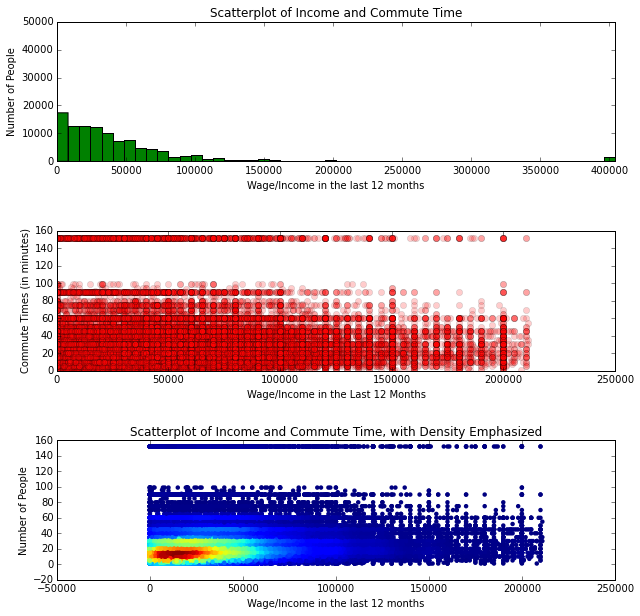

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,10))

#histogram of income
axes[0].hist(data['wage'], 50, facecolor='green')
axes[0].set_xlabel('Wage/Income in the last 12 months')
axes[0].set_ylabel('Number of People')
axes[0].set_title('Histogram of Income')
axes[0].axis([data['wage'].min(), data['wage'].max(), 0, 50000])

#scatterplot of income and commute time
axes[1].plot(data_scaled['wage'], data_scaled['commute'], 'ro', alpha = 0.2)
axes[1].set_xlabel('Wage/Income in the Last 12 Months')
axes[1].set_ylabel('Commute Times (in minutes)')
axes[0].set_title('Scatterplot of Income and Commute Time')

#scatter plot of income and commute time, with density emphasized.
#Redder indicates more people cluster in an area, while blue indicates less.
xy = np.vstack([data_scaled['wage'], data_scaled['commute']])
z = gaussian_kde(xy)(xy)
axes[2].scatter(data_scaled['wage'], data_scaled['commute'], c=z, edgecolor='')
axes[2].set_xlabel('Wage/Income in the last 12 months')
axes[2].set_ylabel('Number of People')
axes[2].set_title('Scatterplot of Income and Commute Time, with Density Emphasized')

fig.subplots_adjust(hspace=.5)
plt.show()


In [69]:
#breaking income into US tax brackets
data['income_group'] = pd.cut(data['wage'], bins = [0,9225,37450,90750,189300,411500],
                             labels = ['lowest', 'low', 'middle','high','very high'])
data['income_group'].value_counts()

low          41768
middle       35011
lowest       12839
high          8752
very high     2356
dtype: int64

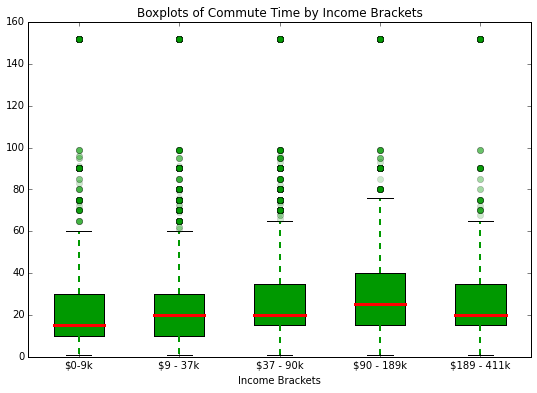

In [112]:
#creating the data to create boxplot
df1 = data.loc[data['income_group'] == 'lowest', 'commute']
df2 = data.loc[data['income_group'] == 'low', 'commute']
df3 = data.loc[data['income_group'] == 'middle', 'commute']
df4 = data.loc[data['income_group'] == 'high', 'commute']
df5 = data.loc[data['income_group'] == 'very high', 'commute']
to_plot = [df1, df2, df3, df4, df5]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(to_plot, patch_artist=True)

#change color of boxes
for box in bp['boxes']:
    box.set( facecolor = '#009900')

#change whiskers of plot
for whisker in bp['whiskers']:
    whisker.set(color='#009900', linewidth=2)
    
#change colors of outliers, decreasing opacity to see density
for flier in bp['fliers']:
    flier.set(marker='o', color='#009900', alpha=0.2)
    
#increase line width of median
for median in bp['medians']:
    median.set(color='#FF0000', linewidth=3)

#change x axis label
ax.set_xticklabels(['$0-9k', '$9 - 37k','$37 - 90k','$90 - 189k', '$189 - 411k', 'Over $411K'])
ax.set_xlabel('Income Brackets')
ax.set_title('Boxplots of Commute Time by Income Brackets')

plt.show()

In [113]:
#calculate Pearson's correlation to examine relationship
pearsonr(data['wage'], data['commute'])

(0.090518490087742862, 2.0191466612338789e-192)

In [ ]:
#Run Kruskal-Wallis Test 

#Run Nemenyi-Damico-Wolfe-Dunn test